In [1]:
import os
import numpy as np
import librosa
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler

In [2]:
def extract_features(audio_file):
    # Load the audio file using librosa
    y, sr = librosa.load(audio_file)

    # Apply pre-emphasis to the audio signal
    pre_emphasis = 0.97
    y = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

    # Extract MFCC (Mel-Frequency Cepstral Coefficients) features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    return np.mean(mfccs.T, axis=0)

In [3]:
# Initialize empty lists to store features and corresponding labels
features = []
labels = []

# Define the path to the main data folder and subfolders for each class
data_folder = 'data_set'
subfolders = ['awake', 'belly_pain', 'burping', 'discomfort', 'hug', 'hungry', 'tired']

# Loop through each subfolder and its corresponding label
for label, subfolder in enumerate(subfolders):
    # Create the full path to the current subfolder
    path = os.path.join(data_folder, subfolder)
    
    # Check if the subfolder exists
    if not os.path.isdir(path):
        print(f"Subfolder {path} not found.")
        continue

    # Iterate over audio files in the current subfolder
    for file_name in tqdm(os.listdir(path), desc=f"Processing {subfolder}"):
        # Check if the file is a WAV audio file
        if file_name.endswith('.wav'):
            # Create the full path to the audio file
            audio_file = os.path.join(path, file_name)
            
            # Extract MFCC features from the audio file
            mfccs = extract_features(audio_file)
            
            # Append the extracted features and corresponding label to lists
            features.append(mfccs)
            labels.append(label)

Processing tired: 100%|██████████| 184/184 [00:05<00:00, 31.72it/s]


In [4]:
# Convert the lists of features and labels into NumPy arrays
features = np.array(features)
labels = np.array(labels)

# Initialize a RandomOverSampler with a fixed random state for reproducibility
ros = RandomOverSampler(random_state=42)

# Resample the data to balance the class distribution
X_res, y_res = ros.fit_resample(features, labels)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [5]:
svm = SVC(C=10, gamma='auto')
svm.fit(X_train, y_train)

SVC(C=10, gamma='auto')

In [6]:
y_pred = svm.predict(X_test)

In [7]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       110
           1       1.00      1.00      1.00        99
           2       1.00      1.00      1.00       114
           3       1.00      0.56      0.72       119
           4       1.00      0.97      0.99       107
           5       0.60      1.00      0.75       105
           6       1.00      0.91      0.95        98

    accuracy                           0.91       752
   macro avg       0.94      0.91      0.91       752
weighted avg       0.94      0.91      0.91       752

Accuracy Score:
0.9082446808510638

Confusion Matrix:
 [[105   0   0   0   0   5   0]
 [  0  99   0   0   0   0   0]
 [  0   0 114   0   0   0   0]
 [  0   0   0  67   0  52   0]
 [  0   0   0   0 104   3   0]
 [  0   0   0   0   0 105   0]
 [  0   0   0   0   0   9  89]]


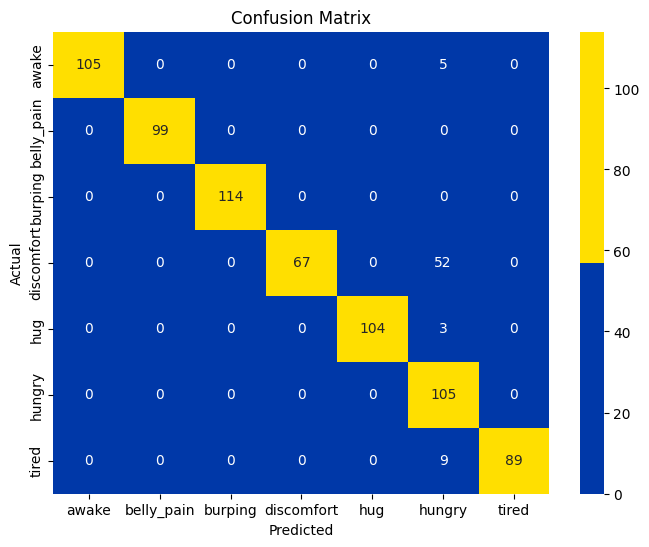

In [8]:
plt.figure(figsize=(8, 6))
yellow = (255 / 255, 223 / 255, 0 / 255)
blue = (0 / 255, 56 / 255, 168 / 255)
custom_cmap = sns.color_palette([blue, yellow])
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap=custom_cmap, xticklabels=subfolders, yticklabels=subfolders)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [9]:
# Define a function to predict the category of an audio file using the model
def predict_audio_file(file_path, model):
    try:
        # Extract MFCC features from the audio file
        mfccs = extract_features(file_path)
        
        # Reshape the MFCC features for prediction
        mfccs = mfccs.reshape(1, -1)
        
        # Make a prediction using the provided model
        prediction = model.predict(mfccs)
        
        # Print the predicted category
        print(f"File: {file_path} | Predicted category: {subfolders[prediction[0]]}")
    except Exception as e:
        print(f"Can't load file {file_path}: {e}")

# Define the path to the folder containing subfolders with audio files
folder_path = "a_p"

# Iterate through each subfolder in the main folder
for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    
    # Check if the subfolder exists
    if not os.path.exists(subfolder_path):
        print(f"Subfolder {subfolder_path} not found.")
        continue

    # Print the name of the subfolder being processed
    print(f"Processing subfolder: {subfolder}")
    
    # Iterate through each audio file in the subfolder and make predictions
    for new_file in os.listdir(subfolder_path):
        file_path = os.path.join(subfolder_path, new_file)
        predict_audio_file(file_path, svm)  # Pass the model 'knn' for prediction

Processing subfolder: awake
File: a_p\awake\awake_0.wav | Predicted category: hungry
File: a_p\awake\awake_130.wav | Predicted category: hungry
File: a_p\awake\awake_16.wav | Predicted category: hungry
File: a_p\awake\awake_83.wav | Predicted category: hungry
Processing subfolder: belly_pain
File: a_p\belly_pain\549a46d8-9c84-430e-ade8-97eae2bef787-1430130772174-1.7-m-48-bp.wav | Predicted category: hungry
File: a_p\belly_pain\BellyPain02.wav | Predicted category: hungry
Processing subfolder: burping
File: a_p\burping\7E4B9C14-F955-4BED-9B03-7F3096A6CBFF-1430540826-1.0-f-26-bu.wav | Predicted category: hungry
File: a_p\burping\Burping-10.wav | Predicted category: hungry
Processing subfolder: discomfort
File: a_p\discomfort\2294E2B2-8E36-4DA6-A898-B947CB9446AB-1436462707-1.1-m-26-dc.wav | Predicted category: hungry
File: a_p\discomfort\Cold_Hot09.wav | Predicted category: discomfort
File: a_p\discomfort\diaper_6.wav | Predicted category: hungry
File: a_p\discomfort\diaper_91.wav | Predi

In [10]:
# # SVM with GridSearchCV
# param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
# grid_search = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=5)
# grid_search.fit(X_train, y_train)

In [11]:
# svc_best_model = grid_search.best_estimator_  
# svc_best_model